In [1]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm, colors
from matplotlib.colors import LinearSegmentedColormap
import sys
sys.path.append('/home/563/rl5183/Documents/CSIRO')
import categorical_enso_functions as func
from dask.distributed import wait

In [3]:
# Dask client
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1)#(memory_limit=None, n_cpus=15≈1)
client.cluster.scale(8) 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45239,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45549,Total threads: 1
Dashboard: /proxy/41267/status,Memory: 0 B
Nanny: tcp://127.0.0.1:37979,


In [4]:
# Silence warnings
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

In [5]:
# Functions for plotting 
def format_gridlines(ax, top_labels=False, bottom_labels=False, left_labels=False, right_labels=False):
    
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top_labels
    gl.bottom_labels = bottom_labels
    gl.right_labels = right_labels
    gl.left_labels = left_labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

In [6]:
# ENSO years
EN = [1963, 1965, 1968, 1969, 1972, 1976, 1977, 1979, 1982, 1986, 1987, 1991, 1994, 1997, 2002, 
      2004, 2006, 2009, 2014, 2015, 2018]

LN = [1964, 1966, 1967, 1970, 1971, 1973, 1974, 1975, 1983, 1984, 1988, 1995, 1996, 1998, 1999, 
      2000, 2005, 2007, 2010, 2011, 2017, 2020, 2021, 2022]

NN = [1960, 1961, 1962, 1978, 1980, 1981, 1985, 1989, 1990, 1992, 1993, 2001, 2003, 2008, 2012, 
      2013, 2016, 2019]

#### AGCD

In [7]:
# AGCD landmask
landmask = xr.open_dataset('/g/data/w40/asp561/agcd/mask_australia_0.05deg.nc').landmask

In [8]:
# AGCD data (v2 for precip) 
file_pattern = "/g/data/zv2/agcd/v2-0-2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{}.nc"
# Generate list of file paths for years 1960-2022
years = range(1960, 2023)  
paths = [file_pattern.format(year) for year in years]
# Open dataset 
precip = xr.open_mfdataset(paths, combine='nested', concat_dim='time', chunks={'time':12, 'lat':'auto', 'lon':'auto'}).precip.persist()
wait(precip);

In [9]:
# Taget La Niña years 
target_years = [1983, 1984, 1988, 1995, 1996, 1998, 1999, 2000, 2005, 2007, 2010, 2011, 2017]

In [10]:
# This is the same as the function in function file but with dims "year" instead of "time"
def spatial_probability_exceed(cdf, anom_data, threshold):
    import xarray as xr
    P = xr.apply_ufunc(
        func.get_probability_exceed, cdf, anom_data, threshold,
        input_core_dims=[["year"], ["year"], []],  # Match time dimension
        output_core_dims=[[]],  # Remove time dim
        vectorize=True,
        dask="parallelized"
    )
    return P

In [11]:
# Calculate quantiles and probability for each forecast year
rainfall_quantiles = []
LN_probabilities = []
target_precip = []


for target_year in target_years:
    
    end_year = target_year - 1
    precip_target = precip.sel(time=f"{target_year}")
    precip_clim = precip.sel(time=slice(None, f"{end_year}-12"))

    precip_son = precip_clim.sel(time=precip_clim.time.dt.season == "SON").groupby("time.year").mean("time")
    precip_son = precip_son.where(landmask.data == 1)

    precip_LN = precip_son.sel(year=precip_son['year'].isin(LN)).chunk(chunks={'year': -1, 'lat': -1, 'lon': -1})
    
    q66_rainfall = precip_son.quantile(0.66, dim='year').chunk(chunks={'lat':-1, 'lon':-1})

    sorted_LN, cdf_LN = xr.apply_ufunc(
    func.empirical_cdf, 
    precip_LN, 
    input_core_dims=[["year"]],
    output_core_dims=[["year"], ["year"]], 
    vectorize=True,
    dask="parallelized"
    )

    P_LN_66th = spatial_probability_exceed(cdf_LN, precip_LN, q66_rainfall)

    precip_target = precip_target.sel(time=precip_target.time.dt.season == "SON").mean("time").where(landmask.data == 1)

    rainfall_quantiles.append(q66_rainfall)
    LN_probabilities.append(P_LN_66th)
    target_precip.append(precip_target)

In [12]:
# Make into xarray dataarray
rainfall_quantiles = xr.concat(rainfall_quantiles, dim="year").assign_coords(year=target_years).persist()
LN_probabilities = xr.concat(LN_probabilities, dim="year").assign_coords(year=target_years)
target_precip = xr.concat(target_precip, dim="year").assign_coords(year=target_years).persist()
wait(target_precip);
wait(LN_probabilities);
wait(target_precip);

In [13]:
# SON
son_yearly = precip.sel(time=precip.time.dt.season == "SON").groupby("time.year").mean("time").where(landmask.data==1).persist()
wait(son_yearly);

#### ACCESS-S2 Lag 0

In [ ]:
ds_ensemble1 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e01/maq5_pr_{}_e01.nc")
wait(ds_ensemble1);
ds_ensemble2 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e02/maq5_pr_{}_e02.nc")
wait(ds_ensemble2);
ds_ensemble3 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e03/maq5_pr_{}_e03.nc")
wait(ds_ensemble3);

In [ ]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# Persist
ds_combined = ds_combined.persist()
wait(ds_combined)

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month 
son_lag0_yearly = ds_combined * 30.33

In [ ]:
target_precip_lag0 = []
above_q66_lag0 = []

for target_year in target_years:
    son_lag0_target = son_lag0_yearly.sel(year=target_year)
    above = (son_lag0_target > rainfall_quantiles.sel(year=target_year)).sum(dim="ensemble") / son_lag0_target.ensemble.size
    target_precip_lag0.append(son_lag0_target)
    above_q66_lag0.append(above)

In [ ]:
target_precip_lag0 = xr.concat(target_precip_lag0, dim="year").assign_coords(year=target_years)
above_q66_lag0 = xr.concat(above_q66_lag0, dim="year").assign_coords(year=target_years)

wait(target_precip_lag0);
wait(above_q66_lag0);

#### ACCESS-S2 Lag 9

In [2]:
ds_ensemble1 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e01/maq5_pr_{}_e01.nc")
wait(ds_ensemble1);
ds_ensemble2 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e02/maq5_pr_{}_e02.nc")
wait(ds_ensemble2);
ds_ensemble3 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e03/maq5_pr_{}_e03.nc")
wait(ds_ensemble3);

In [ ]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# persist
ds_combined = ds_combined.persist()
wait(ds_combined);

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month 
son_lag9_yearly = ds_combined * 30.33

In [ ]:
target_precip_lag9 = []
above_q66_lag9 = []

for target_year in target_years:
    son_lag9_target = son_lag9_yearly.sel(year=target_year)
    above = (son_lag9_target > rainfall_quantiles.sel(year=target_year)).sum(dim="ensemble") / son_lag9_target.ensemble.size
    target_precip_lag9.append(son_lag9_target)
    above_q66_lag9.append(above)

In [ ]:
target_precip_lag9 = xr.concat(target_precip_lag9, dim="year").assign_coords(year=target_years)
above_q66_lag9 = xr.concat(above_q66_lag9, dim="year").assign_coords(year=target_years)

In [ ]:
wait(target_precip_lag9);
wait(above_q66_lag9);

#### Lag 3

In [29]:
ds_ensemble1 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e01/maq5_pr_{}_e01.nc")
wait(ds_ensemble1);
ds_ensemble2 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e02/maq5_pr_{}_e02.nc")
wait(ds_ensemble2);
ds_ensemble3 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e03/maq5_pr_{}_e03.nc")
wait(ds_ensemble3);

In [31]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# persist
ds_combined = ds_combined.persist()
wait(ds_combined);

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month 
son_lag3_yearly = ds_combined * 30.33

#### Plot average SON rainfall (all years) 

In [32]:
pc0 = func.pattern_cor(son_yearly.sel(year=son_lag0_yearly.year).mean(dim='year'), son_lag0_yearly.mean(dim=['year','ensemble']))
pc3 = func.pattern_cor(son_yearly.sel(year=son_lag3_yearly.year).mean(dim='year'), son_lag3_yearly.mean(dim=['year','ensemble']))
pc9 = func.pattern_cor(son_yearly.sel(year=son_lag0_yearly.year).mean(dim='year'), son_lag9_yearly.mean(dim=['year','ensemble']))

In [33]:
cmap_brbg = plt.get_cmap('BrBG')
cmap_green = colors.ListedColormap(cmap_brbg(np.linspace(0.5, 1, 10)))
pr_boundaries = [0, 5, 10, 20, 35, 50, 70, 100, 140, 200]  
pr_norm = colors.BoundaryNorm(pr_boundaries, cmap_green.N)

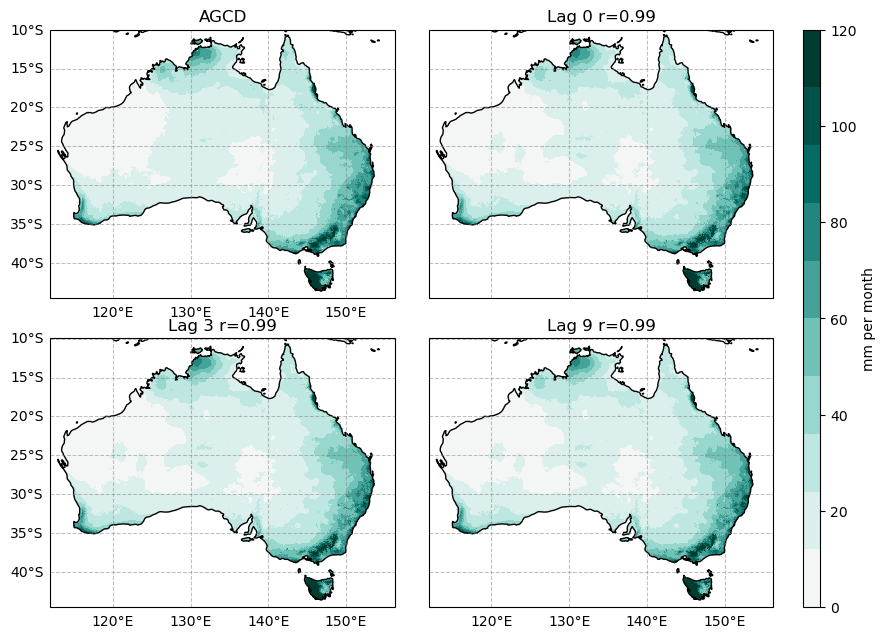

In [34]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])
vmin = 0
vmax = 120

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = son_yearly.sel(year=son_lag0_yearly.year).mean(dim='year').plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('AGCD')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = son_lag0_yearly.mean(dim=['year','ensemble']).plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f'Lag 0 r={pc0:.2f}')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = son_lag3_yearly.mean(dim=['year','ensemble']).plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f'Lag 3 r={pc3:.2f}')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = son_lag9_yearly.mean(dim=['year','ensemble']).plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f'Lag 9 r={pc9:.2f}')
ax = format_gridlines(ax, bottom_labels=True) 

# First colorbar for precip
cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('mm per month');

#### Correlation through time

In [35]:
corr0 = xr.corr(son_yearly.sel(year=son_lag0_yearly.year).chunk({'year':-1}), son_lag0_yearly.mean(dim='ensemble'), dim="year")
corr3 = xr.corr(son_yearly.sel(year=son_lag3_yearly.year).chunk({'year':-1}), son_lag3_yearly.mean(dim='ensemble'), dim="year")
corr9 = xr.corr(son_yearly.sel(year=son_lag9_yearly.year).chunk({'year':-1}), son_lag9_yearly.mean(dim='ensemble'), dim="year")

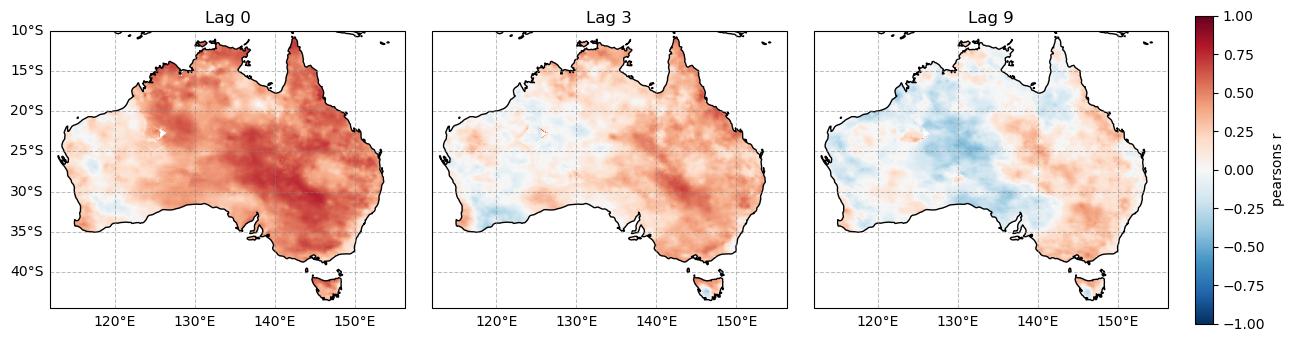

In [38]:
fig = plt.figure(figsize=(15, 4))  
gs = gridspec.GridSpec(1, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
vmin = -1
vmax = 1

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = corr0.plot(ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 0')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = corr3.plot(ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 3')
ax = format_gridlines(ax, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = corr9.plot(ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 9')
ax = format_gridlines(ax, bottom_labels=True)

# First colorbar for precip
cax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('pearsons r');

#### Test year 2017

In [69]:
climatology_prob = ((son_yearly > son_yearly.quantile(0.66, dim="year")).sum(dim="year") / son_yearly.year.size).where(landmask.data==1)

In [66]:
trial_LN_prob = LN_probabilities.sel(year=2017).where(landmask.data == 1)
trial_above_lag0 = above_q66_lag0.sel(year=2017).where(landmask.data == 1)
trial_above_lag9 = above_q66_lag9.sel(year=2017).where(landmask.data == 1)
trial_target_precip = target_precip.sel(year=2017)
trial_q66_rainfall = rainfall_quantiles.sel(year=2017)

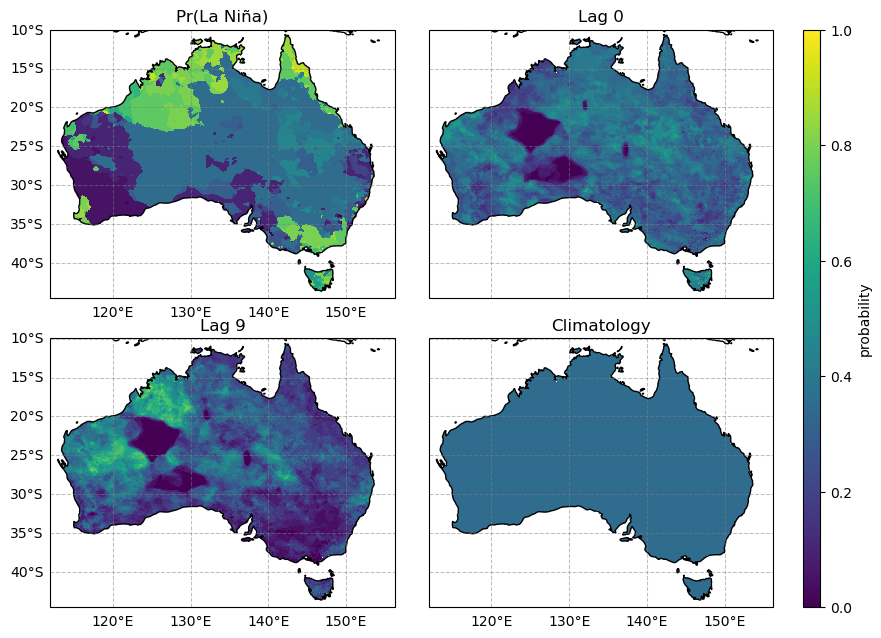

In [71]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])
vmin = 0
vmax = 1
cmap = 'viridis'

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = trial_LN_prob.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Pr(La Niña)')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = trial_above_lag0.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 0')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = trial_above_lag9.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 9')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = climatology_prob.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Climatology')
ax = format_gridlines(ax, bottom_labels=True) 

# First colorbar for precip
cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('probability');

In [72]:
# Convert observed rainfall to binary outcomes (1 = event occurred, 0 = did not occur)
obs_binary = (trial_target_precip > trial_q66_rainfall).astype(int)

# Compute Brier Score for each 
brier_score_LN = ((trial_LN_prob - obs_binary) ** 2)
brier_score_lag0 = ((trial_above_lag0 - obs_binary) ** 2)
brier_score_lag9 = ((trial_above_lag9 - obs_binary) ** 2)

In [74]:
brier_score_clim = ((climatology_prob - obs_binary) ** 2)

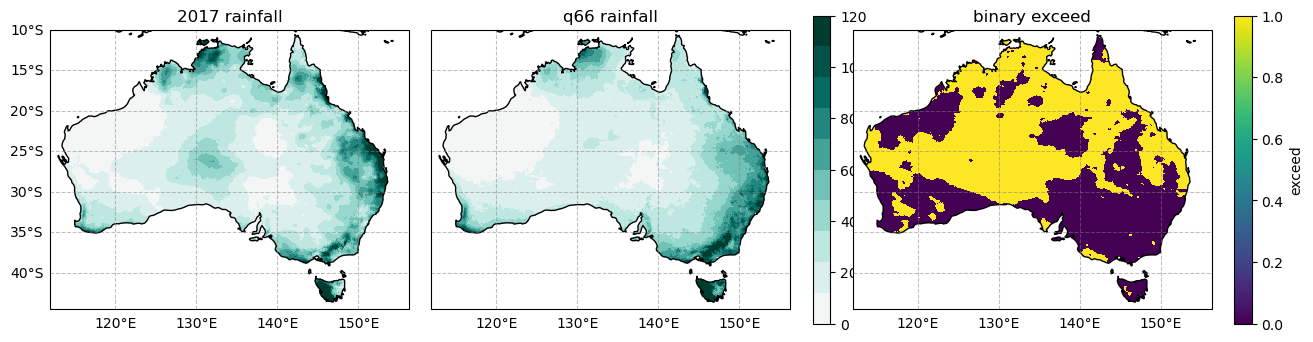

In [73]:
fig = plt.figure(figsize=(15.5, 4))  
gs = gridspec.GridSpec(1, 5, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05, 1, 0.05])
vmin = 0
vmax = 120

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = trial_target_precip.plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('2017 rainfall')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = trial_q66_rainfall.plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q66 rainfall')
ax = format_gridlines(ax, bottom_labels=True)

# First colorbar for precip
cax = plt.subplot(gs[0, 2])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('mm per month');

ax = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree())
im = obs_binary.where(landmask.data==1).plot(ax=ax, cmap='viridis', vmin=0, vmax=1, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('binary exceed')
ax = format_gridlines(ax, bottom_labels=True) 

# second cbar
cax2 = plt.subplot(gs[0, 4])
cbar = plt.colorbar(im, cax2)
cbar.ax.set_ylabel('exceed');

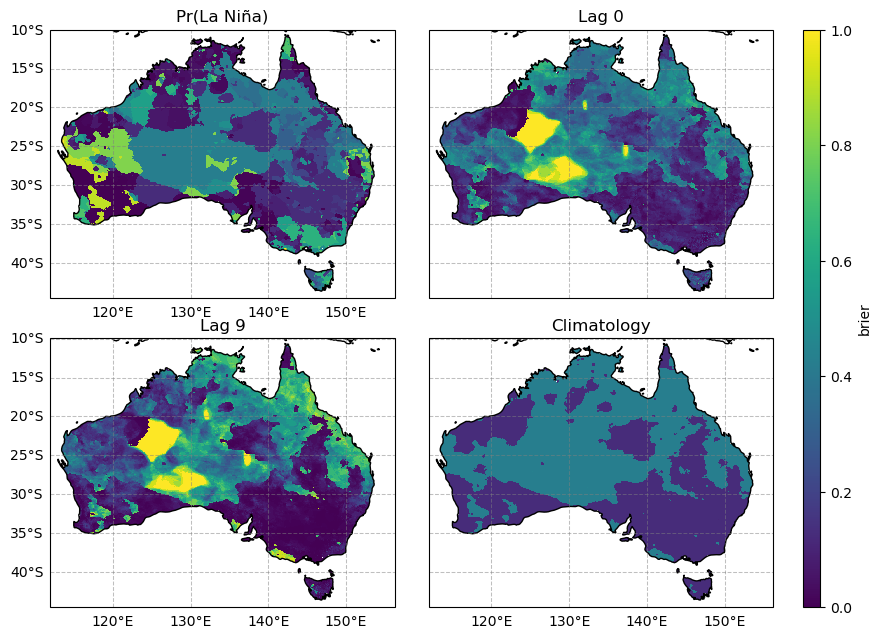

In [75]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])
vmin = 0
vmax = 1
cmap = 'viridis'

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = brier_score_LN.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Pr(La Niña)')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = brier_score_lag0.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 0')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = brier_score_lag9.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 9')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = brier_score_clim.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Climatology')
ax = format_gridlines(ax, bottom_labels=True) 

# First colorbar for precip
cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('brier');

In [76]:
diff_lag0 = brier_score_LN - brier_score_lag0
diff_lag9 = brier_score_LN - brier_score_lag9
diff_clim = brier_score_LN - brier_score_clim

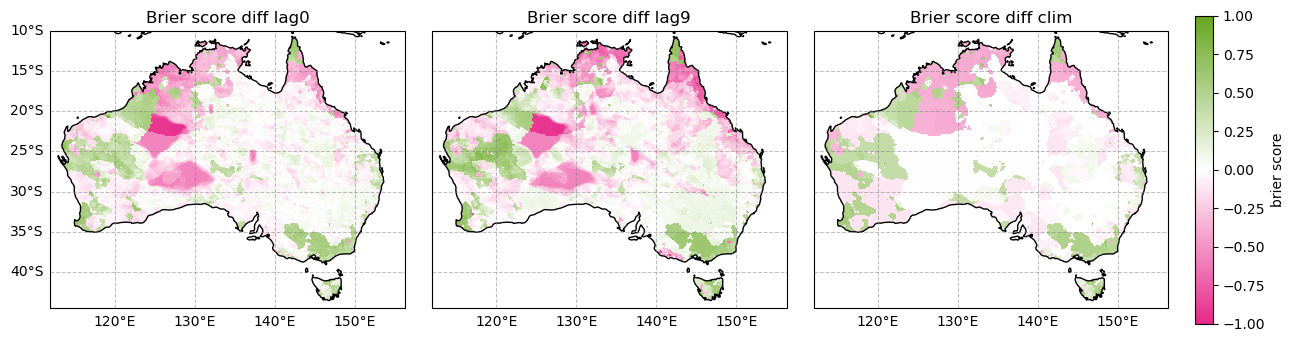

In [78]:
fig = plt.figure(figsize=(15, 4))  
gs = gridspec.GridSpec(1, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
vmin = -1
vmax = 1
cmap = LinearSegmentedColormap.from_list("pink_green", ["#e7298a", "white", "#66a61e"])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = diff_lag0.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff lag0')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = diff_lag9.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff lag9')
ax = format_gridlines(ax, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = diff_clim.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff clim')
ax = format_gridlines(ax, bottom_labels=True) 

# First colorbar for precip
cax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('brier score');

#### All years

In [79]:
brier_LN_means = []
brier_lag0_means = []
brier_lag9_means = []
brier_clim_means = []

diff_lag0_maps = []
diff_lag9_maps = []
diff_clim_maps = []

for year in target_years:
    LN_prob = LN_probabilities.sel(year=year).where(landmask.data == 1)
    above_lag0 = above_q66_lag0.sel(year=year).where(landmask.data == 1)
    above_lag9 = above_q66_lag9.sel(year=year).where(landmask.data == 1)
    precip_target = target_precip.sel(year=year)
    q66_rainfall = rainfall_quantiles.sel(year=year)

    obs_binary = (precip_target > q66_rainfall).astype(int)

    brier_score_LN = ((LN_prob - obs_binary) ** 2)
    brier_score_lag0 = ((above_lag0 - obs_binary) ** 2)
    brier_score_lag9 = ((above_lag9 - obs_binary) ** 2)
    brier_score_clim = ((climatology_prob - obs_binary) ** 2)

    diff_lag0_maps.append(brier_score_LN - brier_score_lag0)
    diff_lag9_maps.append(brier_score_LN - brier_score_lag9)
    diff_clim_maps.append(brier_score_LN - brier_score_clim)

    brier_LN_means.append(brier_score_LN.mean(dim=['lat', 'lon']).values)
    brier_lag0_means.append(brier_score_lag0.mean(dim=['lat', 'lon']).values)
    brier_lag9_means.append(brier_score_lag9.mean(dim=['lat', 'lon']).values)
    brier_clim_means.append(brier_score_clim.mean(dim=['lat', 'lon']).values)

diff_lag0_maps = xr.concat(diff_lag0_maps, dim="year").assign_coords(year=target_years)
diff_lag9_maps = xr.concat(diff_lag9_maps, dim="year").assign_coords(year=target_years)
diff_clim_maps = xr.concat(diff_clim_maps, dim="year").assign_coords(year=target_years)

brier_LN_means = np.array(brier_LN_means)
brier_lag0_means = np.array(brier_lag0_means)
brier_lag9_means = np.array(brier_lag9_means)
brier_clim_means = np.array(brier_clim_means)

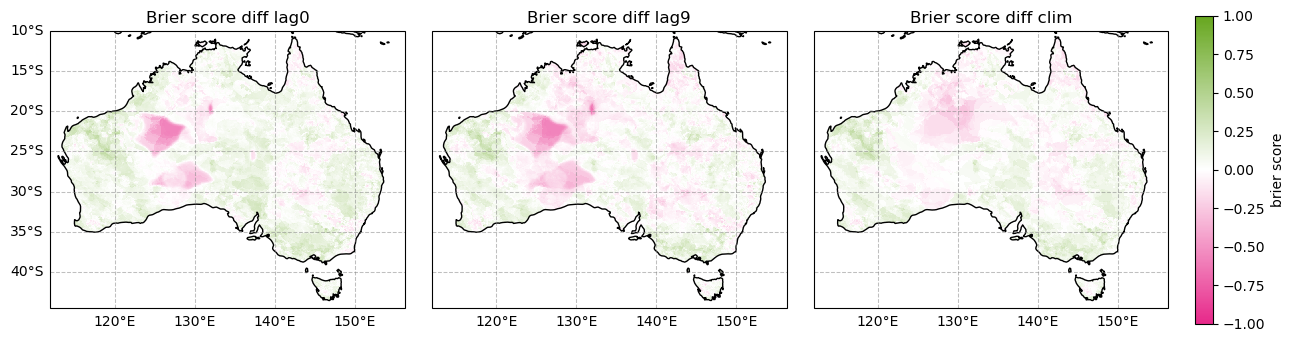

In [80]:
fig = plt.figure(figsize=(15, 4))  
gs = gridspec.GridSpec(1, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
vmin = -1
vmax = 1
cmap = LinearSegmentedColormap.from_list("pink_green", ["#e7298a", "white", "#66a61e"])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = diff_lag0_maps.mean(dim='year').plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff lag0')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = diff_lag9_maps.mean(dim='year').plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff lag9')
ax = format_gridlines(ax, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = diff_clim_maps.mean(dim='year').plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff clim')
ax = format_gridlines(ax, bottom_labels=True) 

# First colorbar for precip
cax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('brier score');

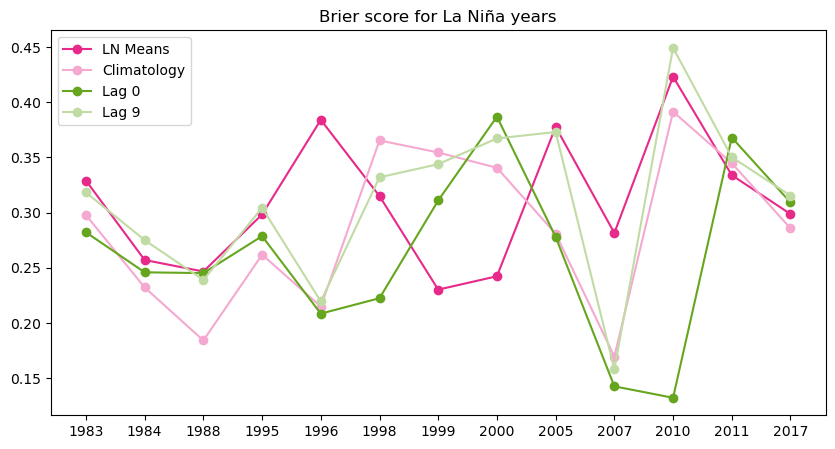

In [81]:
colors = [cmap(0.0), cmap(0.3), cmap(0.7), cmap(1.0)]
brier_x = np.arange(1,14,1)

plt.figure(figsize=(10, 5))

plt.plot(brier_x, brier_LN_means, marker='o', color=colors[0], label='LN Means')  # Dark Pink
plt.plot(brier_x, brier_clim_means, marker='o', color=colors[1], label='Climatology')  # Light Pink
plt.plot(brier_x, brier_lag0_means, marker='o', color=colors[3], label='Lag 0')  # Dark Green
plt.plot(brier_x, brier_lag9_means, marker='o', color=colors[2], label='Lag 9')  # Light Green

plt.title('Brier score for La Niña years')

plt.xticks(brier_x, target_years)
plt.legend()
plt.show()

In [82]:
diff_lag0_clim = brier_score_clim - brier_score_lag0
diff_lag9_clim = brier_score_clim - brier_score_lag9

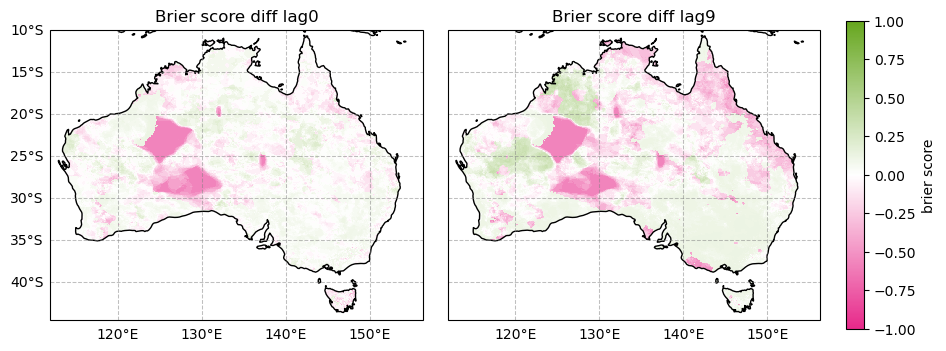

In [83]:
fig = plt.figure(figsize=(10.5, 4))  
gs = gridspec.GridSpec(1, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])
vmin = -1
vmax = 1
cmap = LinearSegmentedColormap.from_list("pink_green", ["#e7298a", "white", "#66a61e"])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = diff_lag0_clim.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff lag0')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = diff_lag9_clim.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff lag9')
ax = format_gridlines(ax, bottom_labels=True) 

# First colorbar for precip
cax = plt.subplot(gs[0, 2])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('brier score');

In [2]:
import os
sys.stderr=open(os.devnull,'w')